# Assignment 3: Fashion MNIST Classification with ANN and Visualizations

##  1. Load and Explore the Fashion MNIST Dataset

Objetive: The main objetive is to develop and evaluate an ANN model using the Fashion MNIST dataset.

**Source:** Fashion MNIST dataset available in Keras

**Dataset information:** The Fashion MNIST dataset, available in Keras, is a set of 70,000 grayscale images of clothing items, each 28x28 pixels in size. It includes 10 categories like T-shirts, dresses, and shoes. There are 60,000 images for training and 10,000 for testing. Fashion-MNIST is a dataset of Zalando's article images, intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits, making it ideal for comparing different models and techniques. This dataset is popular for testing and comparing machine learning models, offering more complexity than the original MNIST dataset of handwritten digits. the pixel (1 to 255)

**Labels:**
Each training and test example is assigned to one of the following labels:

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

**Quick Overview:**
- Each row in the dataset represents a separate image.
- The first column contains the class label (what type of clothing it is).
- The remaining 784 columns represent the pixel values of the 28x28 image.
- Each pixel value ranges from 1 to 255, indicating how dark that pixel is.

## 2.Data Preprocessing

In [77]:
#!pip install tensorflow
#!pip install -q -U keras-tuner

In [155]:
#importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical

In [156]:
tf.__version__

'2.16.2'

In [157]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [158]:
# Printing the shapes and data types to familiarize  with the dataset's structure and the classes it contains.
print(f'x_train shape: {x_train.shape}, dtype: {x_train.dtype}')
print(f'y_train shape: {y_train.shape}, dtype: {y_train.dtype}')
print(f'x_test shape: {x_test.shape}, dtype: {x_test.dtype}')
print(f'y_test shape: {y_test.shape}, dtype: {y_test.dtype}')

x_train shape: (60000, 28, 28), dtype: uint8
y_train shape: (60000,), dtype: uint8
x_test shape: (10000, 28, 28), dtype: uint8
y_test shape: (10000,), dtype: uint8


In [159]:
# Unique labels and their counts
unique, counts = np.unique(y_train, return_counts=True)
label_counts = dict(zip(unique, counts))

print(f'Unique labels: {unique}')
print(f'Label counts: {label_counts}')

Unique labels: [0 1 2 3 4 5 6 7 8 9]
Label counts: {0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}


In [160]:
# Scaling the pixel values to a range between 0 and 1
x_train = x_train / 255.0
x_test = x_test / 255.0

# Reshaping the data for the ANN
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Checking the new shapes
print(f'x_train shape after reshaping: {x_train.shape}')
print(f'x_test shape after reshaping: {x_test.shape}')

x_train shape after reshaping: (60000, 28, 28, 1)
x_test shape after reshaping: (10000, 28, 28, 1)


## 3. Visualizations

Let's create some visualizations to explore the dataset. 

I will start by displaying a few sample images from each class to get a sense of what the data looks like.

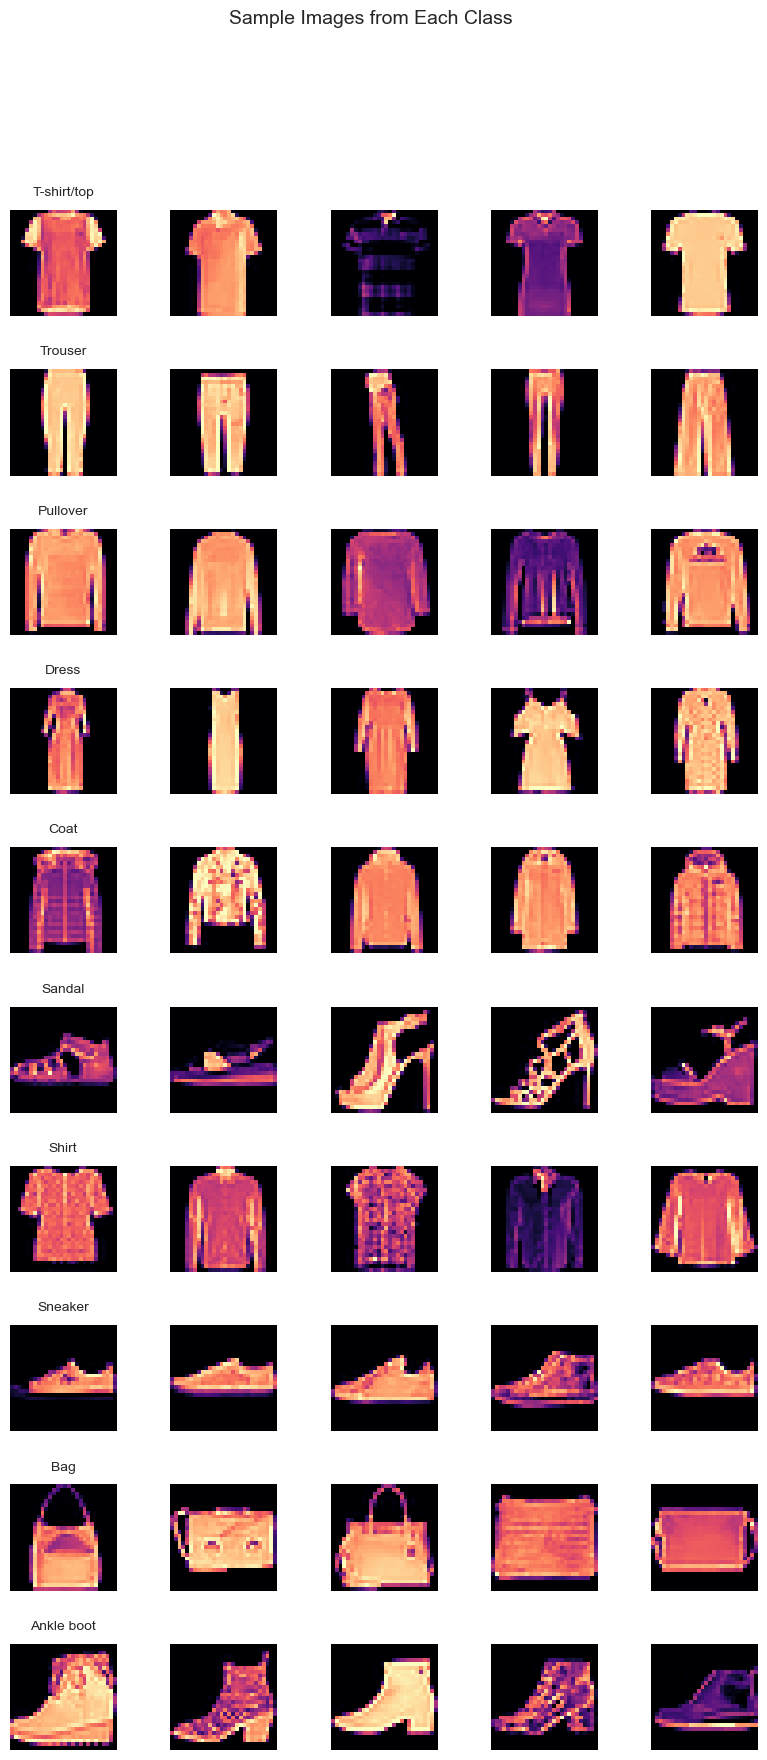

In [161]:
# Display some images from the dataset for each class
def display_sample_images(x, y, class_names, samples_per_class=5, cmap='viridis'):
    fig, axes = plt.subplots(len(class_names), samples_per_class, figsize=(samples_per_class*2, len(class_names)*2))
    fig.subplots_adjust(hspace=0.5)
    
    for i, class_label in enumerate(class_names):
        idxs = np.where(y == i)[0]
        selected_idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for j, idx in enumerate(selected_idxs):
            ax = axes[i, j]
            ax.imshow(x[idx].squeeze(), cmap=cmap)
            ax.axis('off')
            if j == 0:
                ax.set_title(class_label, fontsize=10, pad=10)
    
    plt.suptitle('Sample Images from Each Class', fontsize=14)
    plt.show()

# Displaying sample images with a single class name title per row
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

display_sample_images(x_train, y_train, class_names, samples_per_class=5, cmap='magma')


Next, let's plot these distributions for each class to visually compare the pixel intensity distributions:

- The x-axis represents the pixel intensity values, and the y-axis represents the frequency of these values.
- By examining these histograms, I can see how the pixel values are distributed for each class, providing insights into the visual characteristics of the images.

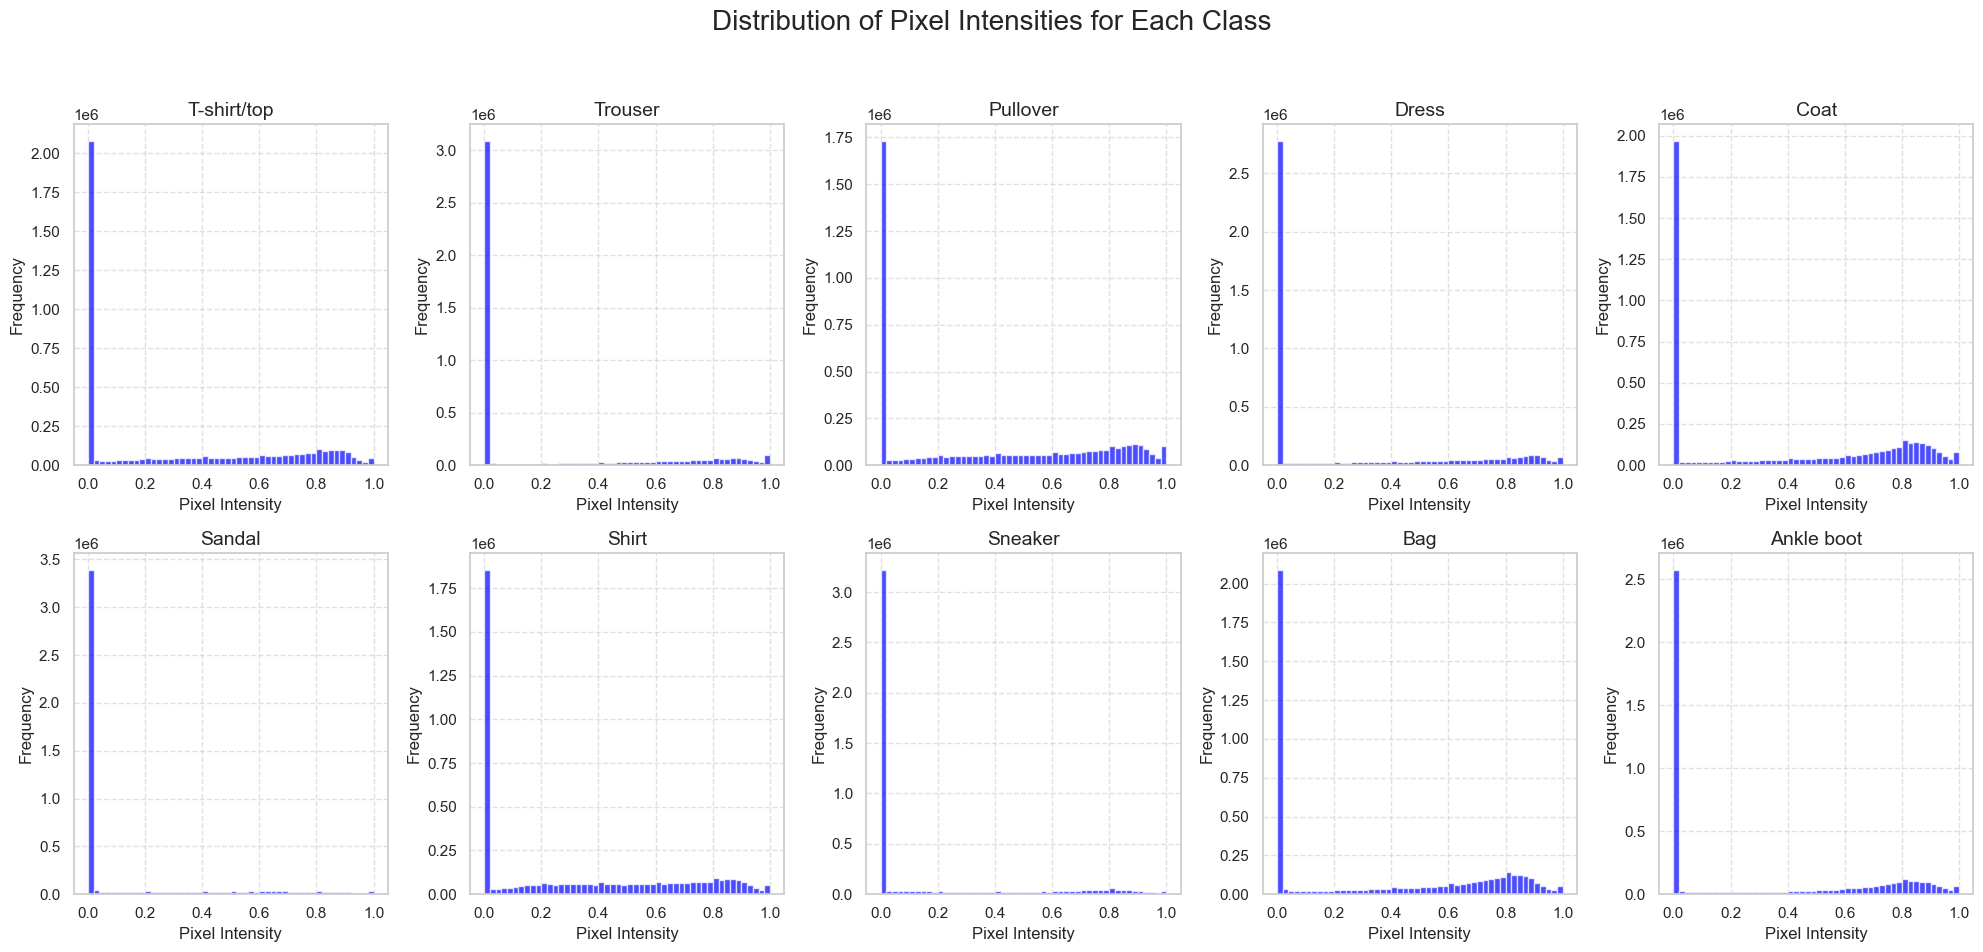

In [162]:
# Histogram of pixel intensities for each class
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, class_label in enumerate(class_names):
    ax = axes[i // 5, i % 5]
    pixel_values = x_train[y_train == i].ravel()
    ax.hist(pixel_values, bins=50, color='blue', alpha=0.7)
    ax.set_xlabel('Pixel Intensity', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(class_label, fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.6)

plt.suptitle('Distribution of Pixel Intensities for Each Class', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Note:**

This distribution shape  give me an idea about the overall brightness and contrast within each class. A more spread-out distribution indicates more variation in pixel intensities, while a concentrated distribution indicates less variation.

## 4.Build an Artificial Neural Network

First, I convert the class labels into one-hot encoded vectors to make them suitable for training the neural network.
Then, I build an Artificial Neural Network (ANN) model using a sequential stack of layers. The model includes convolutional layers to detect patterns, max pooling layers to reduce the spatial dimensions, dropout layers to prevent overfitting, and dense layers to learn complex representations. The final layer uses the softmax activation function to output probabilities for each class, enabling the model to classify the Fashion MNIST images accurately.

In [163]:
# Converting labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [164]:
# Building the ANN model
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

## 5.Compile the Model

For this step I compile the model using the Adam optimizer and categorical cross-entropy loss function, which are well-suited for multi-class classification tasks. 

To evaluate the model's performance comprehensively, I include three metrics: accuracy, precision, and recall. Accuracy measures the overall correctness of the model, precision indicates the accuracy of positive predictions, and recall assesses the model's ability to identify all positive instances, providing a well-rounded evaluation of the model's effectiveness.

In [165]:
# Compiling the model with additional metrics
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'), 
                       tf.keras.metrics.Recall(name='recall')])

## 6.Train the Model

In [166]:
# Training the model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=128)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.6256 - loss: 1.0288 - precision: 0.7880 - recall: 0.4775 - val_accuracy: 0.8235 - val_loss: 0.4752 - val_precision: 0.8878 - val_recall: 0.7445
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.8191 - loss: 0.5008 - precision: 0.8762 - recall: 0.7545 - val_accuracy: 0.8541 - val_loss: 0.4002 - val_precision: 0.8937 - val_recall: 0.8088
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - accuracy: 0.8400 - loss: 0.4430 - precision: 0.8853 - recall: 0.7920 - val_accuracy: 0.8718 - val_loss: 0.3489 - val_precision: 0.8965 - val_recall: 0.8515
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.8579 - loss: 0.3929 - precision: 0.8907 - recall: 0.8216 - val_accuracy: 0.8804 - val_loss: 0.3319 - val_precision: 0.9019 - val_recall: 0.8603
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.8680 - loss: 0.3659 - precision: 0.8971 - recall: 0.8364 - val_accuracy: 0.8861 - va

**Observations:**
-  Over the course of training, the model demonstrated significant improvement in both accuracy and loss metrics, with training accuracy rising from 62.56% to 88.97% and validation accuracy increasing from 82.35% to 89.90%.
-  Training loss decreased from 1.0288 to 0.2967 and validation loss from 0.4752 to 0.2698, indicating effective learning and reduced errors.
-  The model's precision also improved substantially, with training precision increasing from 78.80% to 91.36% and validation precision reaching 91.77%, suggesting a strong ability to correctly identify positive samples.
-  Additionally, training recall saw a significant boost from 47.75% to 86.91%, and validation recall improved from 74.45% to 88.07%, reflecting the model's enhanced capability to identify all relevant positive instances.

## 7.Evaluate the Model

Let´s visualization the metrics:

In [190]:
# Evaluating the model
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(x_test, y_test, verbose=2)
print(f'Test accuracy: {test_accuracy}')
print(f'Test precision: {test_precision}')
print(f'Test recall: {test_recall}')

313/313 - 1s - 3ms/step - accuracy: 0.8990 - loss: 0.2698 - precision: 0.9177 - recall: 0.8807
Test accuracy: 0.8989999890327454
Test precision: 0.9176825881004333
Test recall: 0.8806999921798706


In [191]:
# Extracting the metrics
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']

custom_colors = {
    'acc': 'red',
    'val_acc': 'darkblue',
    'loss': 'seagreen',
    'val_loss': 'firebrick',
    'precision': 'seagreen',
    'val_precision':'firebrick',
    'recall': 'red',
    'val_recall': 'darkblue'
}

epochs = range(len(acc))

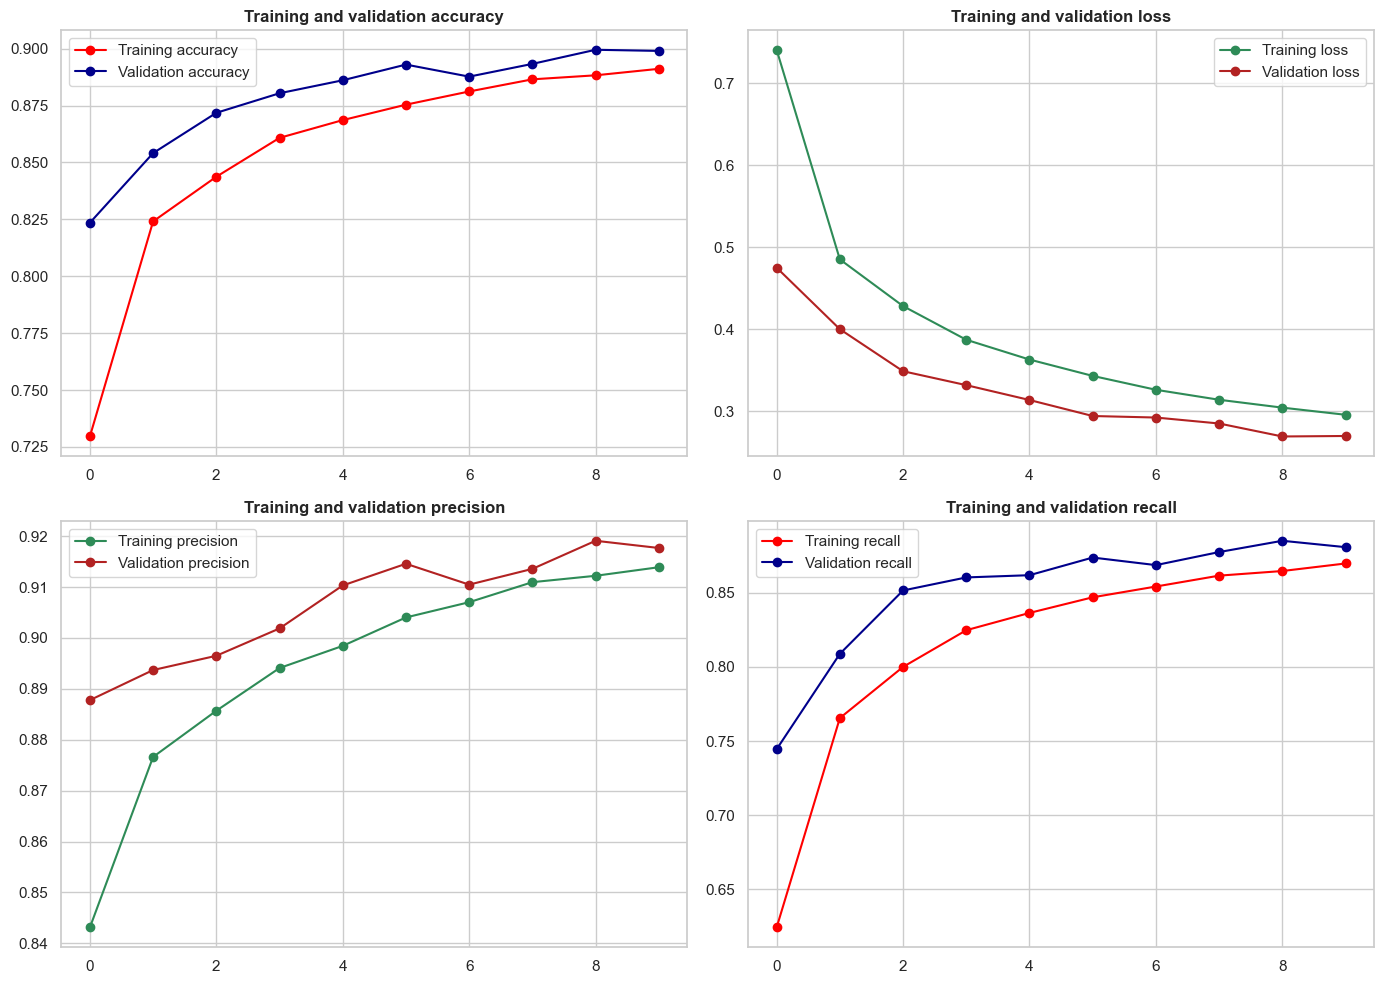

In [192]:
# Function to plot training and validation metrics
def plot_metrics(history):
    epochs = range(len(history.history['accuracy']))

    plt.figure(figsize=(14, 10))

    # Plotting training and validation accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs, acc, marker='o', label='Training accuracy', color=custom_colors['acc'])
    plt.plot(epochs, val_acc, marker='o',label='Validation accuracy', color=custom_colors['val_acc'])
    plt.title('Training and validation accuracy', fontweight='bold')
    plt.legend()

    # Plotting training and validation loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, loss, marker='o', label='Training loss', color=custom_colors['loss'])
    plt.plot(epochs, val_loss, marker='o', label='Validation loss', color=custom_colors['val_loss'])
    plt.title('Training and validation loss', fontweight='bold')
    plt.legend()

    # Plotting training and validation precision
    plt.subplot(2, 2, 3)
    plt.plot(epochs, precision, marker='o', label='Training precision', color=custom_colors['precision'])
    plt.plot(epochs, val_precision, marker='o',label='Validation precision', color=custom_colors['val_precision'])
    plt.title('Training and validation precision', fontweight='bold')
    plt.legend()

    # Plotting training and validation recall
    plt.subplot(2, 2, 4)
    plt.plot(epochs, recall, marker='o', label='Training recall', color=custom_colors['recall'])
    plt.plot(epochs, val_recall, marker='o', label='Validation recall', color=custom_colors['val_recall'])
    plt.title('Training and validation recall', fontweight='bold')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualize the metrics
plot_metrics(history)

**Note:** In overall, these metrics indicate that the model is generalizing well to unseen data and maintaining high performance, making it a robust classifier for the Fashion MNIST dataset.

## 8.Test Set Prediction

In this step I use the trained model to predict the classes for the test set images, providing us with the model's best guesses for each image. To make the results more interpretable, I  define the class names corresponding to the Fashion MNIST dataset labels, then create a function to plot a sample of these predictions alongside the true labels.Each subplot shows an image with its true label and the predicted label, allowing us to visually assess the model's performance on individual test set samples. This helps in understanding how well the model generalizes to new, unseen data.

In [193]:
# Use the trained model to predict the classes for the test set images
predictions = model.predict(x_test)

# Class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Function to plot sample predictions
def plot_sample_predictions(x, y_true, y_pred, class_names, n_samples=20):
    plt.figure(figsize=(20, 10))
    for i in range(n_samples):
        plt.subplot(4, 5, i+1)  # Create a 5x6 grid for 20 images
        plt.imshow(x[i].reshape(28, 28), cmap='viridis')
        true_label = class_names[np.argmax(y_true[i])]
        predicted_label = class_names[np.argmax(y_pred[i])]
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


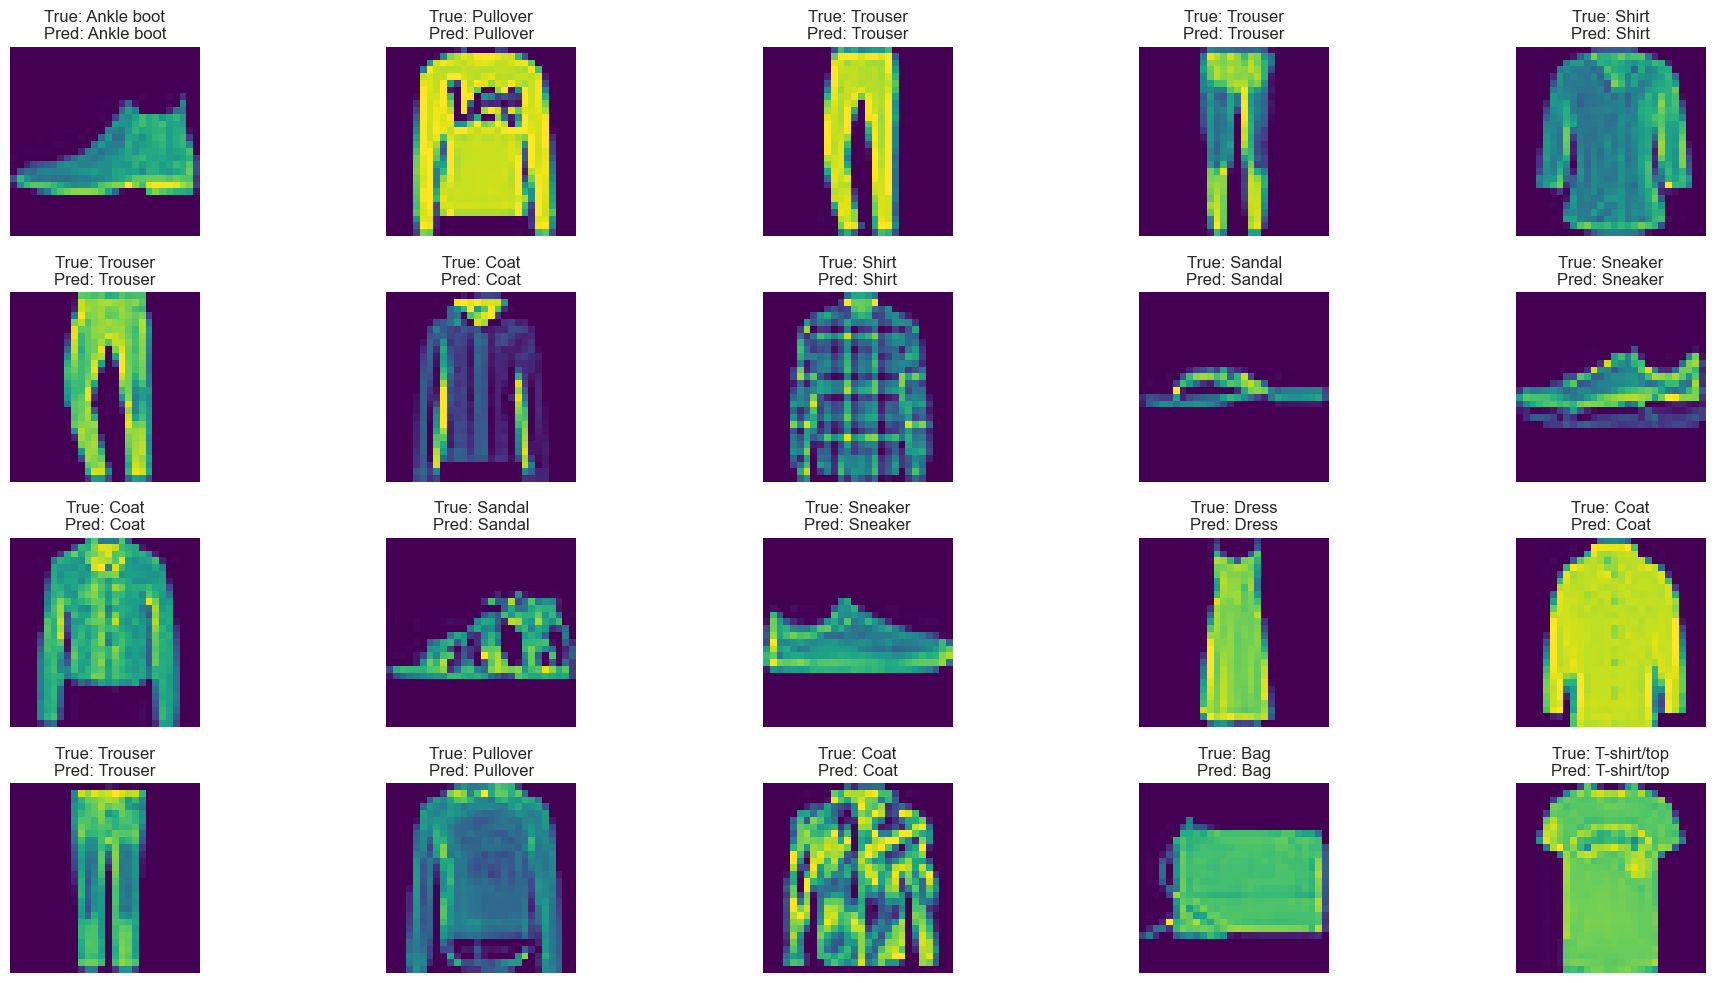

In [194]:
plot_sample_predictions(x_test, y_test, predictions, class_names)

In conclusion, the trained model performed excellently on the test set, accurately predicting the Fashion MNIST images. High accuracy, precision, and recall metrics, along with visual confirmation of sample predictions, indicate that the model generalizes well to new data. This demonstrates that the model is a reliable and effective classifier for the dataset.